In [52]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [53]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    

GPU is available


# MLP 

In [54]:
class MLPNet(nn.Module):
    def __init__(self, 
                 in_dim, # input dimension
                 out_dim, # output dimension
                 hidden_dim, # hidden dimension
                 num_layers # number of layers
                ):
        
        super(MLPNet, self).__init__()
        
        self.model = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        
        for i in range(num_layers-2):
            self.model += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]
        
        self.model += [nn.Linear(hidden_dim, out_dim)]
        
        self.model = nn.Sequential(*self.model)
        
    def forward(self, inp):
        
        # Flatten the last two dimensions
        inp = inp.reshape(inp.shape[0], -1)
        
        out = self.model(inp)
        
        #bz x outputlength x 2
        return out.reshape(inp.shape[0], -1, 2)

In [3]:
# Autogressive vs. direct mapping
# Batch Norm? 

# Dataset

In [55]:
class ArgoverseDataset(torch.utils.data.Dataset):
    """Dataset class for Argoverse"""
    
    def __init__(self, 
                 data_path,
                 sample_indices):
        super(ArgoverseDataset, self).__init__()
        
        self.data_path = data_path
        self.sample_indices = sample_indices
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        
        # Load one scene
        pkl_path = self.pkl_list[self.sample_indices[idx]]
        with open(pkl_path, 'rb') as f:
            scene = pickle.load(f)
            
        # the index of agent to be predicted 
        pred_id = np.where(scene["track_id"] == scene['agent_id'])[0][0]
        
        # input: p_in & v_in; output: p_out
        inp_scene = np.dstack([scene['p_in'], scene['v_in']])
        out_scene = np.dstack([scene['p_out'], scene['v_out']])
        
        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        # Normalize by vectors
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        out = (out_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        # Convert to float torch tensor
        return torch.from_numpy(inp).float(), torch.from_numpy(out[:,:2]).float()

In [5]:
# Try different ways of normalization
# Leverage other features. 

# Hyperparameter

In [6]:
# Grid/Random Search

In [56]:
# batch_size = 64
batch_size = 512
in_dim = 19*4
out_dim = 30*2
hidden_dim = 256 #128
num_layers = 3
learning_rate = 0.01
decay_rate = 0.95
num_epoch = 1000

# Data Loader

In [7]:
# train_path = "./train/train"

# # total number of scenes
# indices = np.arange(0, 1000)

# # train-valid split
# np.random.shuffle(indices)
# train_indices = indices[:900]
# valid_indices = indices[900:]

# # define datasets
# train_set = ArgoverseDataset(train_path, train_indices)
# valid_set = ArgoverseDataset(train_path, valid_indices)

# # create dataloaders
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
# valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [57]:
train_path = "../train/train"

# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:180000]
valid_indices = indices[180000:]

# define datasets
train_set = ArgoverseDataset(train_path, train_indices)
valid_set = ArgoverseDataset(train_path, valid_indices)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [26]:
for inp, out in train_loader:
    print(inp.shape)
    print(out.shape)
    break

torch.Size([512, 19, 2])
torch.Size([512, 30, 2])


# Model, Loss Function and Optimizer

In [58]:
# RNN, LSTM, 1dCNN, Transformer
model = MLPNet(in_dim = in_dim, 
               out_dim = out_dim,
               hidden_dim = hidden_dim, 
               num_layers = num_layers).to(device) # move model to gpu 

# Adaptive Moment Estimation computes adaptive learning rates for each parameter. 
# Compute the decaying averages of past and past squared gradients. 

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decay_rate)  # stepwise learning rate decay
loss_fun = nn.MSELoss()

In [12]:
train_path = "../train/train/"
train_pkl_list = glob(os.path.join(train_path, '*'))
train_pkl_list.sort()

train_preds = []
for idx in range(3):
    with open(train_pkl_list[idx], 'rb') as f:
        train_sample = pickle.load(f)
        pred_id = np.where(train_sample["track_id"] == train_sample['agent_id'])[0][0]
        inp_scene = np.dstack([train_sample['p_in'], train_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        preds = model(inp).cpu().data.numpy()
        
        # De-Normalization ! 
        preds = preds * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        train_preds.append(preds)

In [14]:
predictions = np.concatenate(train_preds).reshape(len(train_preds), -1).astype(int)

In [16]:
predictions.shape

(3, 60)

In [ ]:
predictions

# Training

In [59]:
len(train_loader)

352

In [60]:
def train_epoch(train_loader, model, optimizer, loss_function):
    train_mse = []
    for inp, tgt in tqdm(train_loader):
        inp = inp.to(device)
        tgt = tgt.to(device)
        
        #print("starting pred")
        pred = model(inp)
        #print("make pred")
        
        loss = loss_function(pred, tgt)
        train_mse.append(loss.item()) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_mse = round(np.sqrt(np.mean(train_mse)),5)
    return train_mse

def eval_epoch(valid_loader, model, loss_function):
    valid_mse = []
    preds = []
    trues = []
    with torch.no_grad():
        for inp, tgt in valid_loader:
            inp = inp.to(device)
            tgt = tgt.to(device)
            
            loss = 0
            pred = model(inp)
            loss = loss_function(pred, tgt)
            preds.append(pred.cpu().data.numpy())
            trues.append(tgt.cpu().data.numpy())
            valid_mse.append(loss.item())
            
        preds = np.concatenate(preds, axis = 0)  
        trues = np.concatenate(trues, axis = 0)  
        valid_mse = round(np.sqrt(np.mean(valid_mse)), 5)
    return valid_mse, preds, trues


In [14]:
# Learning Rate Decay
# Dropout
# L1/L2 Regulization

 44%|████▍     | 155/352 [01:52<02:30,  1.31it/s]


 88%|████████▊ | 309/352 [04:15<00:38,  1.11it/s]


100%|██████████| 352/352 [04:59<00:00,  1.18it/s]


Epoch 1 | T: 5.87 | Train RMSE: 0.09093 | Valid RMSE: 0.03239


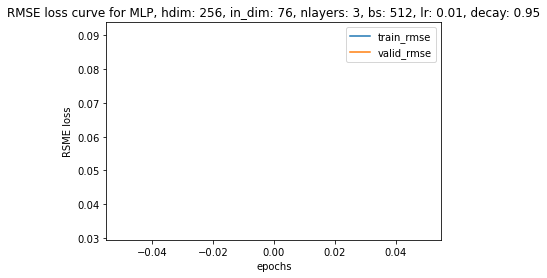

 44%|████▍     | 154/352 [02:15<02:46,  1.19it/s]


 88%|████████▊ | 308/352 [04:48<00:35,  1.25it/s]


100%|██████████| 352/352 [05:26<00:00,  1.08it/s]


Epoch 2 | T: 6.17 | Train RMSE: 0.02308 | Valid RMSE: 0.01924


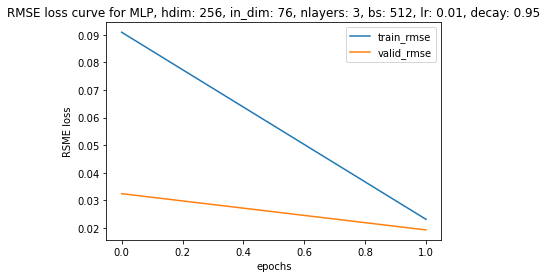

 44%|████▍     | 154/352 [01:56<02:00,  1.64it/s]


 88%|████████▊ | 308/352 [04:08<00:29,  1.49it/s]


100%|██████████| 352/352 [04:46<00:00,  1.23it/s]


Epoch 3 | T: 5.29 | Train RMSE: 0.02174 | Valid RMSE: 0.01873


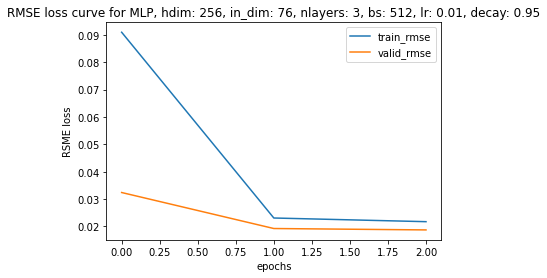

 44%|████▍     | 154/352 [01:55<01:54,  1.72it/s]


 88%|████████▊ | 308/352 [03:57<00:26,  1.68it/s]


100%|██████████| 352/352 [04:33<00:00,  1.29it/s]


Epoch 4 | T: 5.23 | Train RMSE: 0.02107 | Valid RMSE: 0.01884


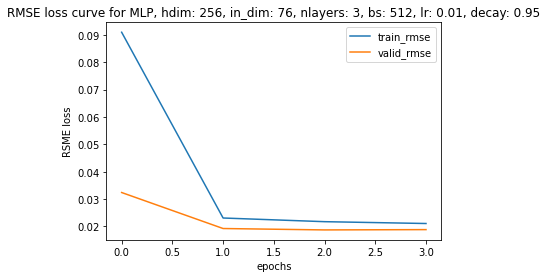

 44%|████▍     | 154/352 [01:41<01:45,  1.87it/s]


 88%|████████▊ | 308/352 [03:36<00:25,  1.71it/s]


100%|██████████| 352/352 [04:11<00:00,  1.40it/s]


Epoch 5 | T: 4.64 | Train RMSE: 0.01908 | Valid RMSE: 0.03181


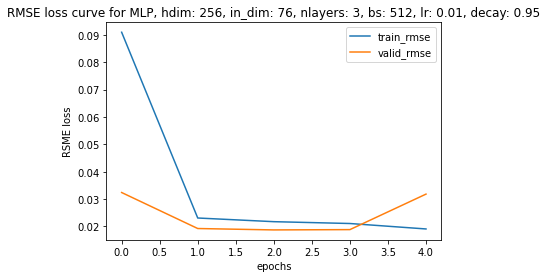

 44%|████▍     | 154/352 [01:53<01:46,  1.86it/s]


 88%|████████▊ | 308/352 [03:44<00:23,  1.91it/s]


100%|██████████| 352/352 [04:08<00:00,  1.42it/s]


Epoch 6 | T: 4.75 | Train RMSE: 0.01928 | Valid RMSE: 0.01708


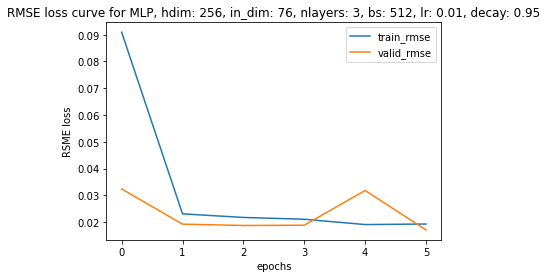

 44%|████▍     | 154/352 [01:52<01:41,  1.95it/s]


 88%|████████▊ | 308/352 [03:23<00:21,  2.01it/s]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


Epoch 7 | T: 4.70 | Train RMSE: 0.01821 | Valid RMSE: 0.01418


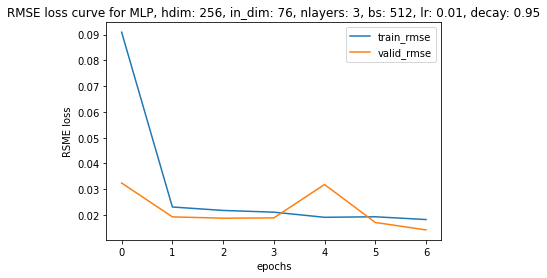

 44%|████▍     | 154/352 [01:34<01:34,  2.09it/s]


 88%|████████▊ | 308/352 [03:28<00:23,  1.84it/s]


100%|██████████| 352/352 [04:06<00:00,  1.43it/s]


Epoch 8 | T: 4.51 | Train RMSE: 0.01849 | Valid RMSE: 0.01691


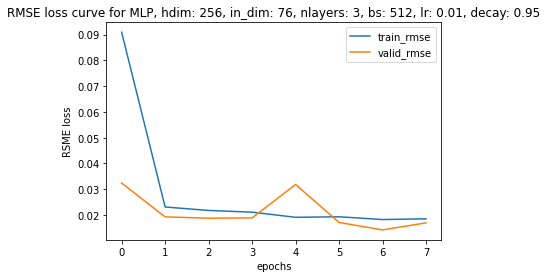

 44%|████▍     | 154/352 [01:47<01:40,  1.97it/s]


 88%|████████▊ | 308/352 [03:32<00:46,  1.05s/it]


100%|██████████| 352/352 [03:55<00:00,  1.50it/s]


Epoch 9 | T: 4.59 | Train RMSE: 0.01643 | Valid RMSE: 0.01383


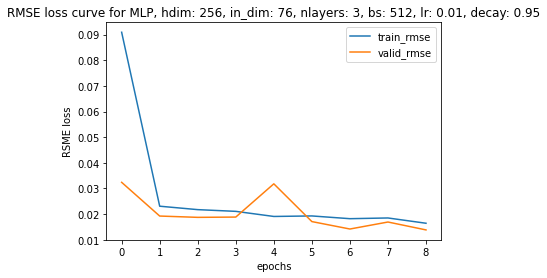

 44%|████▍     | 154/352 [01:34<01:40,  1.98it/s]


 88%|████████▊ | 308/352 [03:18<00:22,  1.99it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


Epoch 10 | T: 4.42 | Train RMSE: 0.01599 | Valid RMSE: 0.01680


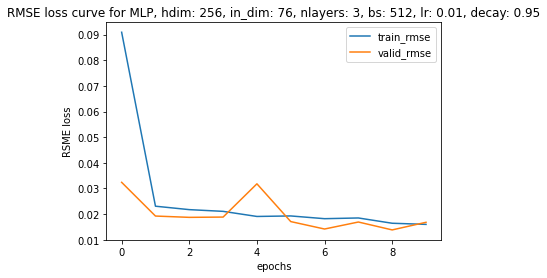

 44%|████▍     | 154/352 [01:48<01:33,  2.11it/s]


 88%|████████▊ | 308/352 [03:37<00:53,  1.22s/it]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


Epoch 11 | T: 4.70 | Train RMSE: 0.01645 | Valid RMSE: 0.01516


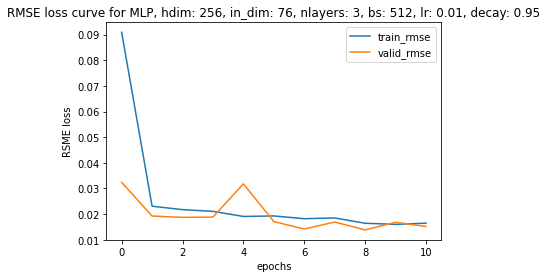

 44%|████▍     | 154/352 [01:29<01:34,  2.09it/s]


 88%|████████▊ | 308/352 [03:15<00:20,  2.16it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


Epoch 12 | T: 4.37 | Train RMSE: 0.01501 | Valid RMSE: 0.01312


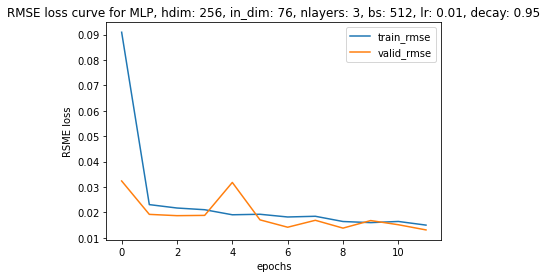

 44%|████▍     | 154/352 [01:48<01:34,  2.10it/s]


 88%|████████▊ | 308/352 [03:34<00:28,  1.52it/s]


100%|██████████| 352/352 [03:55<00:00,  1.50it/s]


Epoch 13 | T: 4.67 | Train RMSE: 0.01436 | Valid RMSE: 0.01237


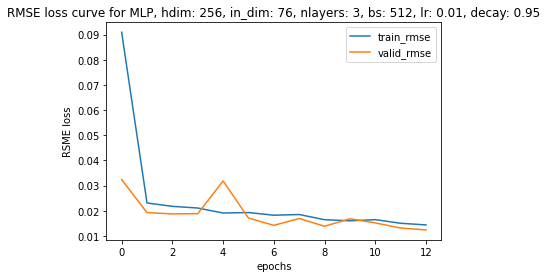

 44%|████▍     | 154/352 [01:43<10:29,  3.18s/it]


 88%|████████▊ | 308/352 [03:11<00:21,  2.06it/s]


100%|██████████| 352/352 [03:55<00:00,  1.50it/s]


Epoch 14 | T: 4.32 | Train RMSE: 0.01437 | Valid RMSE: 0.01104


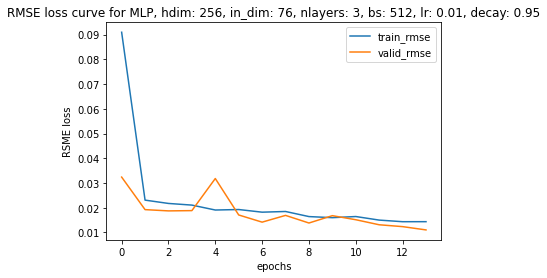

 44%|████▍     | 154/352 [01:49<01:34,  2.09it/s]


 88%|████████▊ | 308/352 [03:31<00:41,  1.07it/s]


100%|██████████| 352/352 [03:53<00:00,  1.51it/s]


Epoch 15 | T: 4.71 | Train RMSE: 0.01356 | Valid RMSE: 0.01502


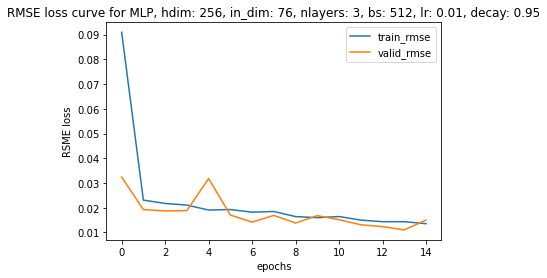

 44%|████▍     | 154/352 [01:43<02:11,  1.50it/s]


 88%|████████▊ | 308/352 [03:09<00:19,  2.22it/s]


100%|██████████| 352/352 [03:53<00:00,  1.51it/s]


Epoch 16 | T: 4.29 | Train RMSE: 0.01302 | Valid RMSE: 0.01307


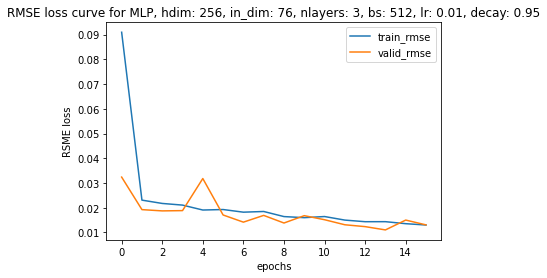

 44%|████▍     | 154/352 [01:50<01:39,  1.98it/s]


 88%|████████▊ | 308/352 [03:28<01:27,  2.00s/it]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


Epoch 17 | T: 4.73 | Train RMSE: 0.01269 | Valid RMSE: 0.01446


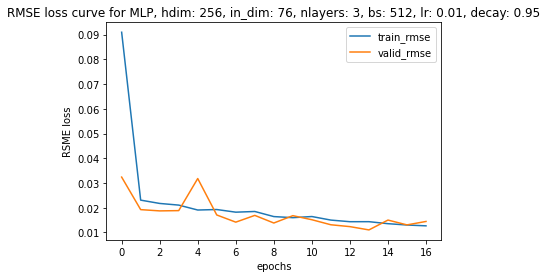

 44%|████▍     | 154/352 [01:44<01:41,  1.96it/s]


 88%|████████▊ | 308/352 [03:10<00:22,  1.96it/s]


100%|██████████| 352/352 [03:52<00:00,  1.51it/s]


Epoch 18 | T: 4.30 | Train RMSE: 0.01194 | Valid RMSE: 0.00978


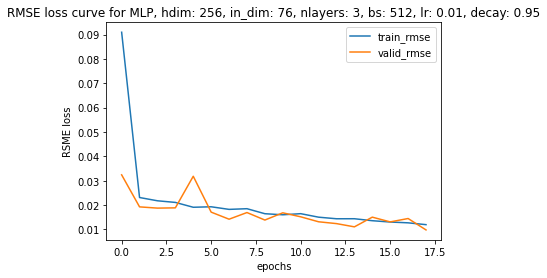

 44%|████▍     | 154/352 [01:54<01:40,  1.97it/s]


 88%|████████▊ | 308/352 [03:31<00:22,  1.99it/s]


100%|██████████| 352/352 [03:52<00:00,  1.51it/s]


Epoch 19 | T: 4.74 | Train RMSE: 0.01124 | Valid RMSE: 0.01018


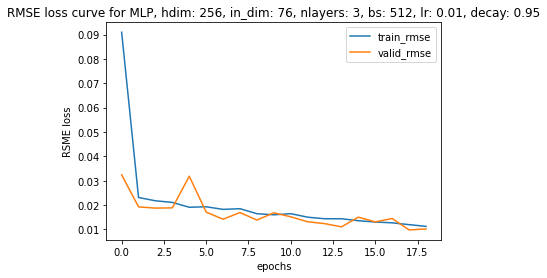

 44%|████▍     | 154/352 [01:48<01:34,  2.11it/s]


 88%|████████▊ | 308/352 [03:09<00:20,  2.16it/s]


100%|██████████| 352/352 [03:50<00:00,  1.52it/s]


Epoch 20 | T: 4.27 | Train RMSE: 0.01094 | Valid RMSE: 0.01156


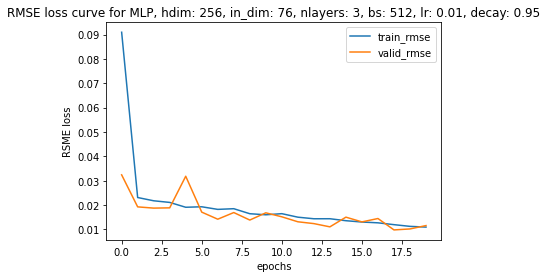

 44%|████▍     | 154/352 [02:02<01:36,  2.05it/s]


 88%|████████▊ | 308/352 [03:36<00:21,  2.09it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 21 | T: 4.76 | Train RMSE: 0.01048 | Valid RMSE: 0.00829


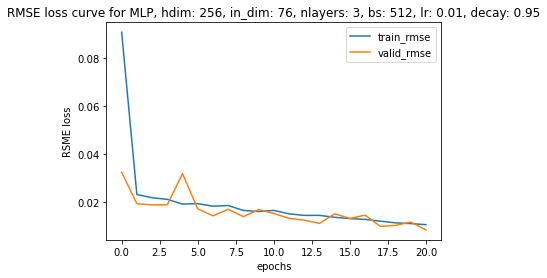

 44%|████▍     | 154/352 [01:50<01:43,  1.92it/s]


 88%|████████▊ | 308/352 [03:13<00:22,  2.00it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


Epoch 22 | T: 4.25 | Train RMSE: 0.01016 | Valid RMSE: 0.00858


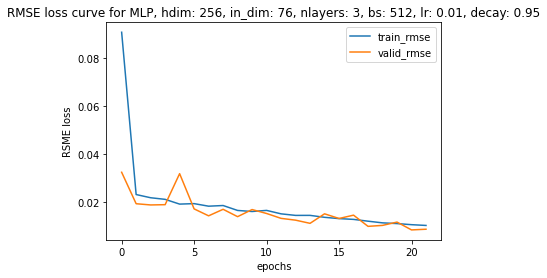

 44%|████▍     | 154/352 [02:04<01:30,  2.19it/s]


 88%|████████▊ | 308/352 [03:37<00:21,  2.04it/s]


100%|██████████| 352/352 [03:58<00:00,  1.48it/s]


Epoch 23 | T: 4.71 | Train RMSE: 0.00982 | Valid RMSE: 0.01063


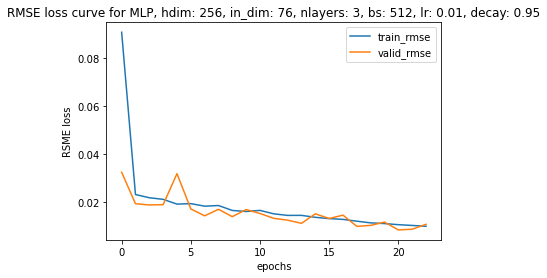

 44%|████▍     | 154/352 [02:01<01:37,  2.03it/s]


 88%|████████▊ | 308/352 [03:20<00:21,  2.07it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 24 | T: 4.34 | Train RMSE: 0.00973 | Valid RMSE: 0.01925


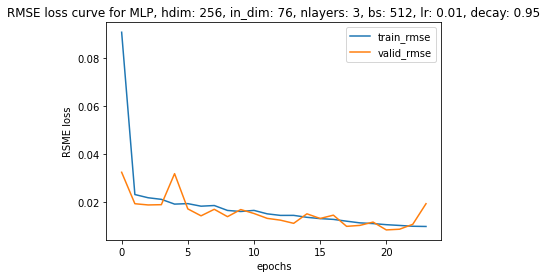

 44%|████▍     | 154/352 [02:07<01:37,  2.04it/s]


 88%|████████▊ | 308/352 [03:34<00:20,  2.17it/s]


100%|██████████| 352/352 [03:55<00:00,  1.49it/s]


Epoch 25 | T: 4.66 | Train RMSE: 0.00929 | Valid RMSE: 0.00951


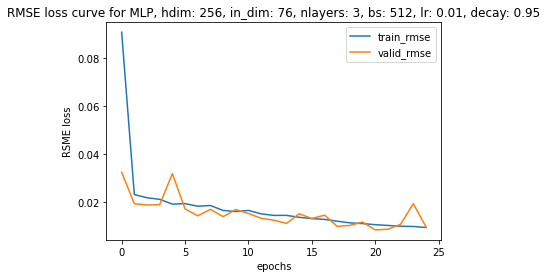

 44%|████▍     | 154/352 [02:02<01:33,  2.12it/s]


 88%|████████▊ | 308/352 [03:19<00:21,  2.08it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 26 | T: 4.32 | Train RMSE: 0.00925 | Valid RMSE: 0.01080


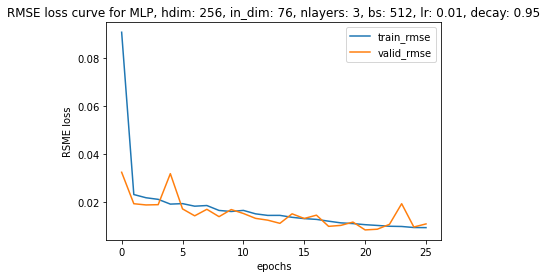

 44%|████▍     | 154/352 [02:08<01:37,  2.03it/s]


 88%|████████▊ | 308/352 [03:35<00:20,  2.15it/s]


100%|██████████| 352/352 [03:55<00:00,  1.50it/s]


Epoch 27 | T: 4.63 | Train RMSE: 0.00892 | Valid RMSE: 0.00780


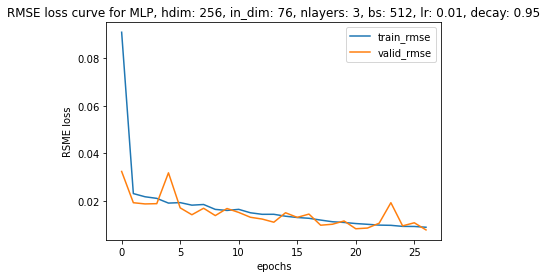

 44%|████▍     | 154/352 [02:05<01:38,  2.01it/s]


 88%|████████▊ | 308/352 [03:24<00:21,  2.06it/s]


100%|██████████| 352/352 [03:58<00:00,  1.47it/s]


Epoch 28 | T: 4.38 | Train RMSE: 0.00859 | Valid RMSE: 0.00715


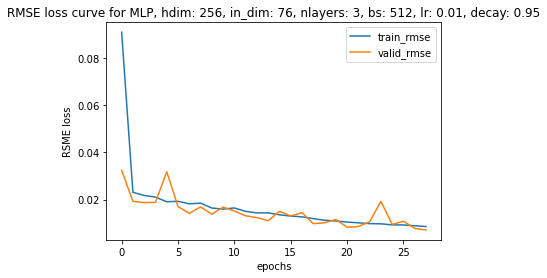

 44%|████▍     | 154/352 [02:07<01:40,  1.97it/s]


 88%|████████▊ | 308/352 [03:38<00:20,  2.11it/s]


100%|██████████| 352/352 [03:58<00:00,  1.47it/s]


Epoch 29 | T: 4.67 | Train RMSE: 0.00850 | Valid RMSE: 0.00790


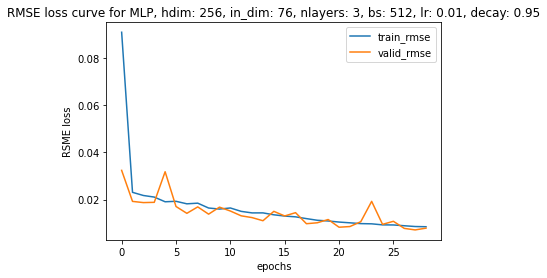

 44%|████▍     | 154/352 [02:06<01:30,  2.20it/s]


 88%|████████▊ | 308/352 [03:24<00:19,  2.22it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


Epoch 30 | T: 4.34 | Train RMSE: 0.00822 | Valid RMSE: 0.00681


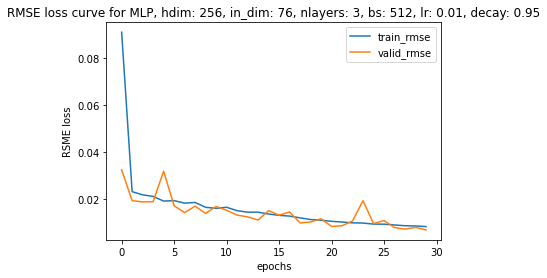

 44%|████▍     | 154/352 [02:08<01:30,  2.20it/s]


 88%|████████▊ | 308/352 [03:39<00:20,  2.13it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


Epoch 31 | T: 4.65 | Train RMSE: 0.00790 | Valid RMSE: 0.01141


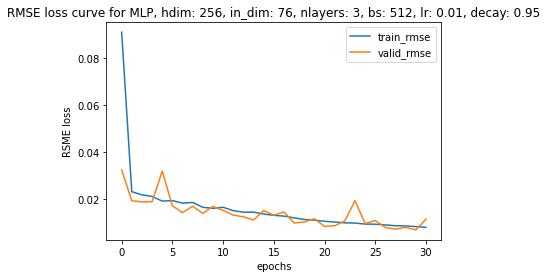

 44%|████▍     | 154/352 [02:06<01:43,  1.91it/s]


 88%|████████▊ | 308/352 [03:25<00:20,  2.15it/s]


100%|██████████| 352/352 [03:58<00:00,  1.47it/s]


Epoch 32 | T: 4.38 | Train RMSE: 0.00795 | Valid RMSE: 0.00765


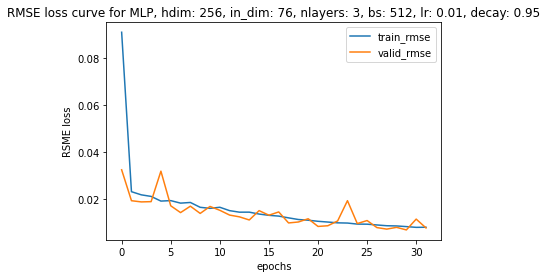

 44%|████▍     | 154/352 [02:02<01:29,  2.22it/s]


 88%|████████▊ | 308/352 [03:39<00:20,  2.12it/s]


100%|██████████| 352/352 [04:00<00:00,  1.47it/s]


Epoch 33 | T: 4.67 | Train RMSE: 0.00778 | Valid RMSE: 0.00705


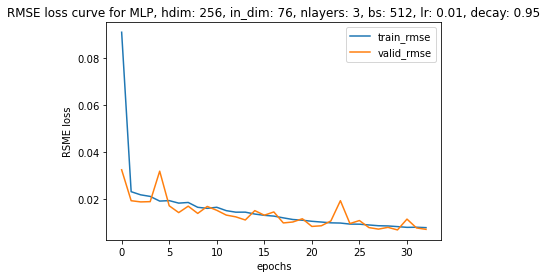

 44%|████▍     | 154/352 [02:04<01:36,  2.05it/s]


 88%|████████▊ | 308/352 [03:27<00:21,  2.03it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


Epoch 34 | T: 4.39 | Train RMSE: 0.00757 | Valid RMSE: 0.00716


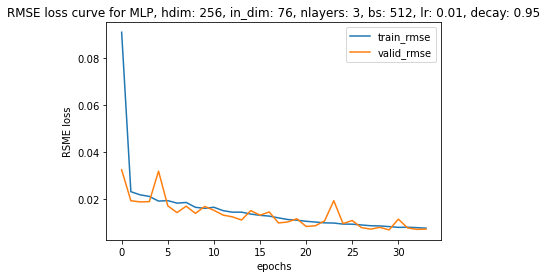

 44%|████▍     | 154/352 [01:55<01:37,  2.02it/s]


 88%|████████▊ | 308/352 [03:39<00:22,  1.98it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


Epoch 35 | T: 4.60 | Train RMSE: 0.00725 | Valid RMSE: 0.00667


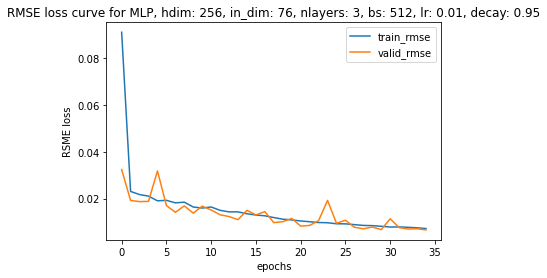

 44%|████▍     | 154/352 [02:04<02:04,  1.59it/s]


 88%|████████▊ | 308/352 [03:28<00:20,  2.10it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


Epoch 36 | T: 4.37 | Train RMSE: 0.00723 | Valid RMSE: 0.00737


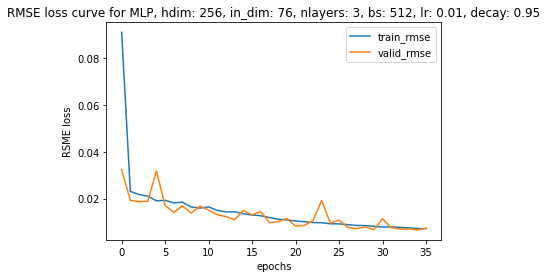

 44%|████▍     | 154/352 [01:59<01:30,  2.19it/s]


 88%|████████▊ | 308/352 [03:39<00:19,  2.21it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


Epoch 37 | T: 4.63 | Train RMSE: 0.00704 | Valid RMSE: 0.00617


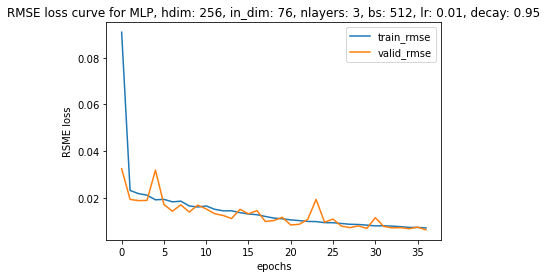

 44%|████▍     | 154/352 [01:57<01:57,  1.68it/s]


 88%|████████▊ | 308/352 [03:20<00:20,  2.16it/s]


100%|██████████| 352/352 [03:58<00:00,  1.48it/s]


Epoch 38 | T: 4.35 | Train RMSE: 0.00692 | Valid RMSE: 0.00716


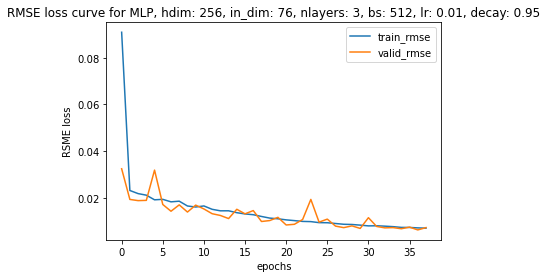

 44%|████▍     | 154/352 [01:54<01:35,  2.08it/s]


 88%|████████▊ | 308/352 [03:39<00:22,  1.96it/s]


100%|██████████| 352/352 [04:01<00:00,  1.46it/s]


Epoch 39 | T: 4.65 | Train RMSE: 0.00677 | Valid RMSE: 0.01036


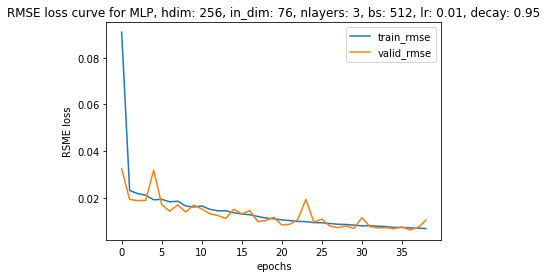

 44%|████▍     | 154/352 [01:32<01:31,  2.16it/s]


 88%|████████▊ | 308/352 [03:24<00:21,  2.03it/s]


100%|██████████| 352/352 [04:01<00:00,  1.46it/s]


Epoch 40 | T: 4.41 | Train RMSE: 0.00671 | Valid RMSE: 0.00828


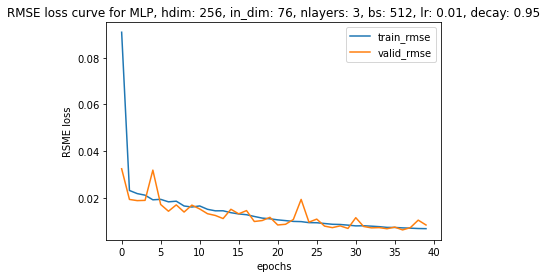

 44%|████▍     | 154/352 [01:48<01:37,  2.04it/s]


 88%|████████▊ | 308/352 [03:34<00:23,  1.85it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 41 | T: 4.54 | Train RMSE: 0.00652 | Valid RMSE: 0.00578


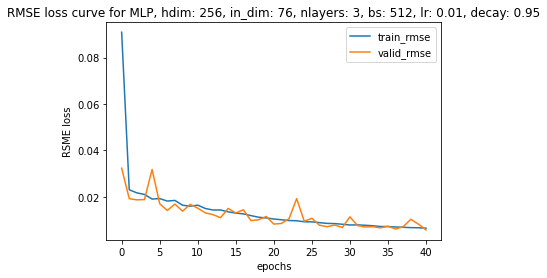

 44%|████▍     | 154/352 [01:35<01:38,  2.01it/s]


 88%|████████▊ | 308/352 [03:22<00:21,  2.06it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


Epoch 42 | T: 4.41 | Train RMSE: 0.00640 | Valid RMSE: 0.00591


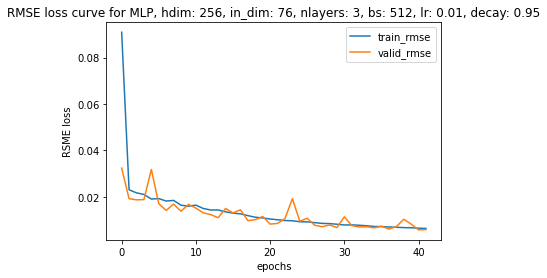

 44%|████▍     | 154/352 [01:50<01:39,  2.00it/s]


 88%|████████▊ | 308/352 [03:37<03:30,  4.77s/it]


100%|██████████| 352/352 [03:58<00:00,  1.48it/s]


Epoch 43 | T: 4.69 | Train RMSE: 0.00634 | Valid RMSE: 0.00575


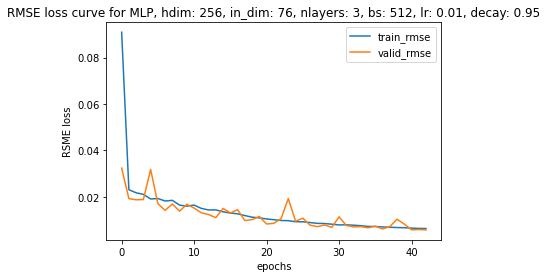

 44%|████▍     | 154/352 [01:31<01:32,  2.13it/s]


 88%|████████▊ | 308/352 [03:17<00:20,  2.11it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


Epoch 44 | T: 4.38 | Train RMSE: 0.00616 | Valid RMSE: 0.00630


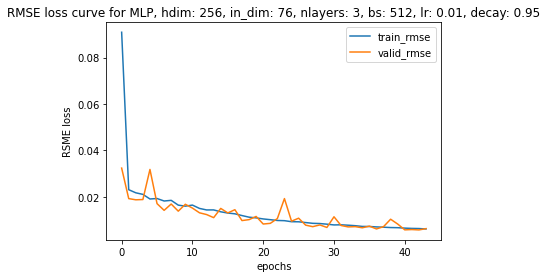

 44%|████▍     | 154/352 [01:48<01:38,  2.01it/s]


 88%|████████▊ | 308/352 [03:36<02:02,  2.78s/it]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


Epoch 45 | T: 4.70 | Train RMSE: 0.00595 | Valid RMSE: 0.00541


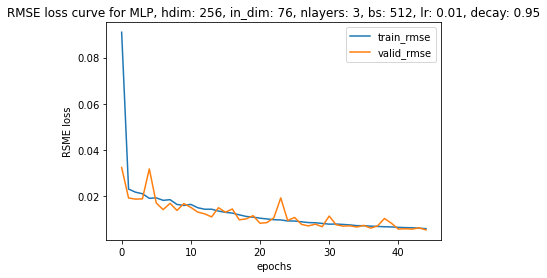

 44%|████▍     | 154/352 [01:31<01:29,  2.21it/s]


 88%|████████▊ | 308/352 [03:12<00:19,  2.22it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


Epoch 46 | T: 4.40 | Train RMSE: 0.00596 | Valid RMSE: 0.00596


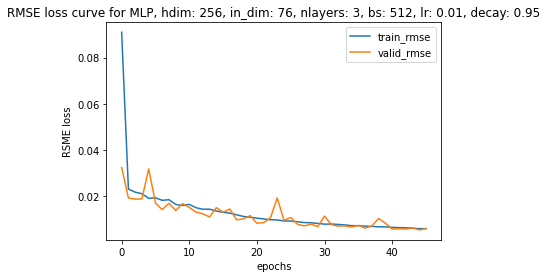

 44%|████▍     | 154/352 [01:45<01:28,  2.24it/s]


 88%|████████▊ | 308/352 [03:34<03:04,  4.19s/it]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


Epoch 47 | T: 4.70 | Train RMSE: 0.00577 | Valid RMSE: 0.00585


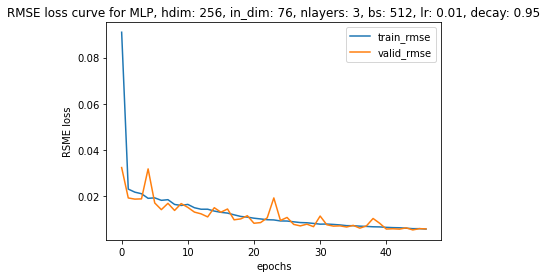

 44%|████▍     | 154/352 [01:26<01:30,  2.19it/s]


 88%|████████▊ | 308/352 [03:08<00:22,  1.92it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


Epoch 48 | T: 4.33 | Train RMSE: 0.00573 | Valid RMSE: 0.00557


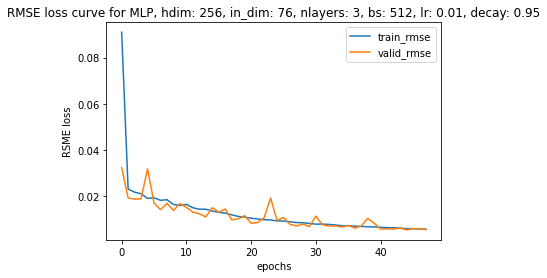

 44%|████▍     | 154/352 [01:45<01:34,  2.09it/s]


 88%|████████▊ | 308/352 [03:35<00:28,  1.56it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 49 | T: 4.70 | Train RMSE: 0.00564 | Valid RMSE: 0.00532


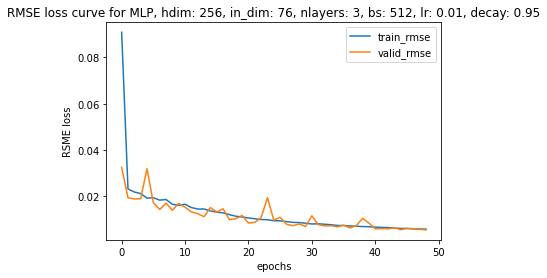

 44%|████▍     | 154/352 [01:44<01:57,  1.68it/s]


 88%|████████▊ | 308/352 [03:10<00:20,  2.11it/s]


100%|██████████| 352/352 [04:00<00:00,  1.46it/s]


Epoch 50 | T: 4.41 | Train RMSE: 0.00560 | Valid RMSE: 0.00493


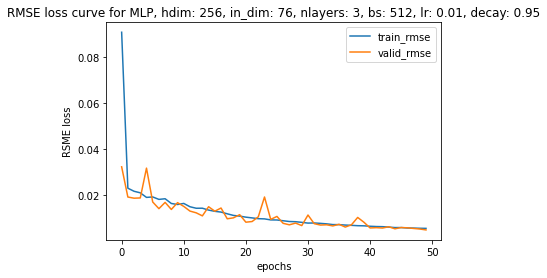

 44%|████▍     | 154/352 [01:47<01:37,  2.04it/s]


 88%|████████▊ | 308/352 [03:34<00:21,  2.05it/s]


100%|██████████| 352/352 [03:55<00:00,  1.49it/s]


Epoch 51 | T: 4.73 | Train RMSE: 0.00544 | Valid RMSE: 0.00571


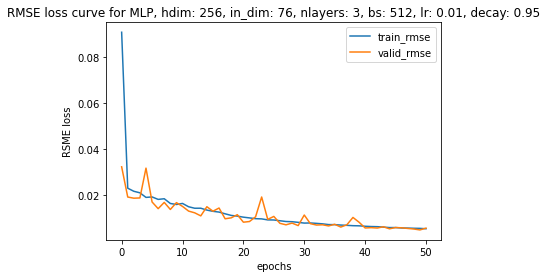

 44%|████▍     | 154/352 [01:44<01:38,  2.01it/s]


 88%|████████▊ | 308/352 [03:12<00:18,  2.41it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


Epoch 52 | T: 4.67 | Train RMSE: 0.00540 | Valid RMSE: 0.00525


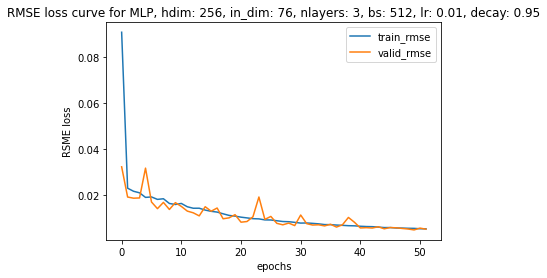

 44%|████▍     | 154/352 [01:30<01:36,  2.04it/s]


 88%|████████▊ | 308/352 [03:12<00:20,  2.18it/s]


100%|██████████| 352/352 [03:33<00:00,  1.65it/s]


Epoch 53 | T: 4.39 | Train RMSE: 0.00528 | Valid RMSE: 0.00475


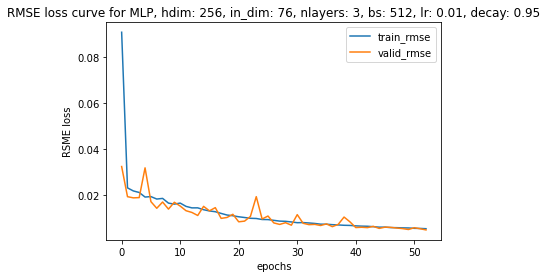

 44%|████▍     | 154/352 [01:49<01:35,  2.07it/s]


 88%|████████▊ | 308/352 [03:11<00:20,  2.19it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 54 | T: 4.78 | Train RMSE: 0.00519 | Valid RMSE: 0.00470


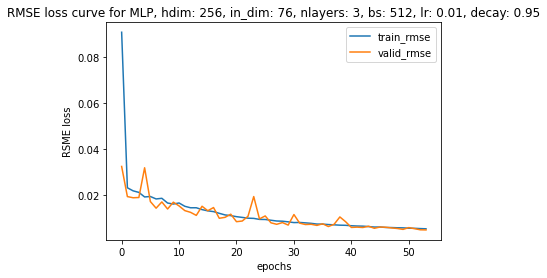

 18%|█▊        | 62/352 [00:28<02:07,  2.28it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


 79%|███████▉  | 278/352 [03:20<03:19,  2.70s/it]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 58 | T: 4.74 | Train RMSE: 0.00505 | Valid RMSE: 0.00485


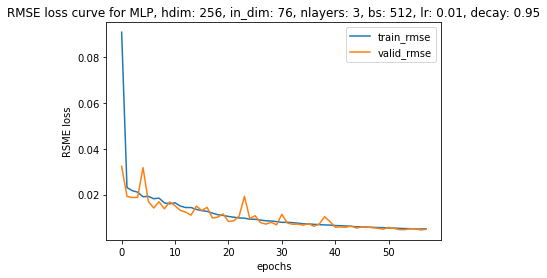

 44%|████▍     | 154/352 [01:47<01:37,  2.03it/s]


 88%|████████▊ | 308/352 [03:10<00:20,  2.16it/s]


100%|██████████| 352/352 [03:53<00:00,  1.51it/s]


Epoch 59 | T: 4.28 | Train RMSE: 0.00485 | Valid RMSE: 0.00520


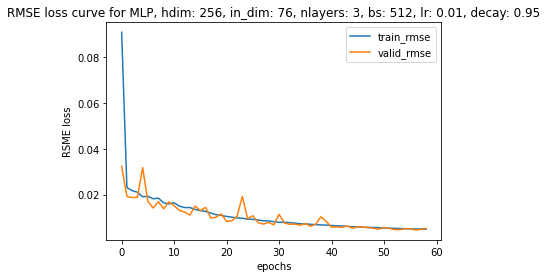

 44%|████▍     | 154/352 [01:54<01:36,  2.05it/s]


 88%|████████▊ | 308/352 [03:32<00:20,  2.15it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


Epoch 60 | T: 4.80 | Train RMSE: 0.00488 | Valid RMSE: 0.00486


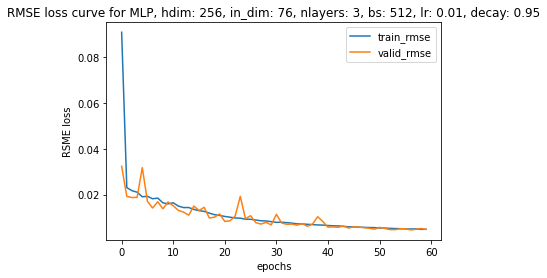

 44%|████▍     | 154/352 [01:44<01:32,  2.13it/s]


 88%|████████▊ | 308/352 [03:08<00:22,  1.97it/s]


100%|██████████| 352/352 [03:52<00:00,  1.52it/s]


Epoch 61 | T: 4.68 | Train RMSE: 0.00485 | Valid RMSE: 0.00449


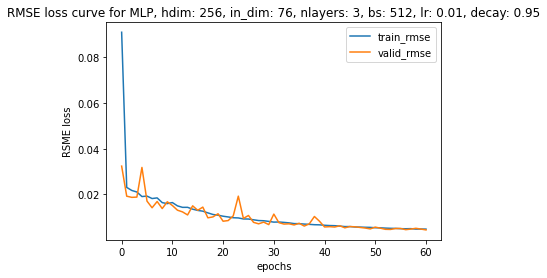

 44%|████▍     | 154/352 [01:31<01:30,  2.18it/s]


 88%|████████▊ | 308/352 [03:09<00:22,  2.00it/s]


100%|██████████| 352/352 [03:30<00:00,  1.68it/s]


Epoch 62 | T: 4.32 | Train RMSE: 0.00475 | Valid RMSE: 0.00467


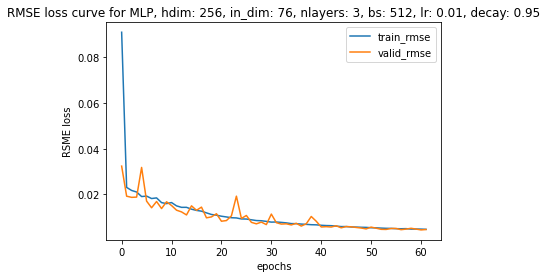

 44%|████▍     | 154/352 [01:50<01:38,  2.01it/s]


 88%|████████▊ | 308/352 [03:11<00:20,  2.10it/s]


100%|██████████| 352/352 [03:49<00:00,  1.54it/s]


Epoch 63 | T: 4.21 | Train RMSE: 0.00475 | Valid RMSE: 0.00475


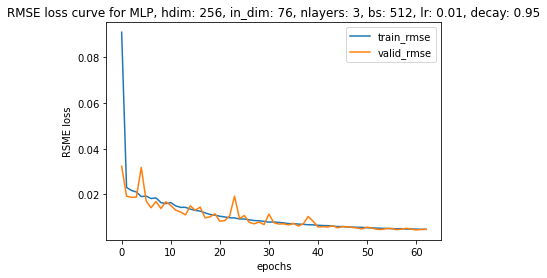

 44%|████▍     | 154/352 [02:12<04:37,  1.40s/it]


 88%|████████▊ | 308/352 [03:39<00:21,  2.06it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


Epoch 64 | T: 4.84 | Train RMSE: 0.00464 | Valid RMSE: 0.00442


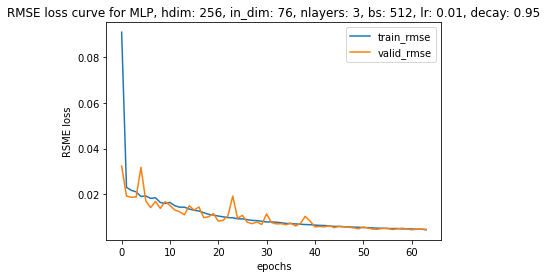

 44%|████▍     | 154/352 [01:53<01:35,  2.07it/s]


 88%|████████▊ | 308/352 [03:12<00:19,  2.20it/s]


100%|██████████| 352/352 [03:52<00:00,  1.51it/s]


Epoch 65 | T: 4.84 | Train RMSE: 0.00469 | Valid RMSE: 0.00480


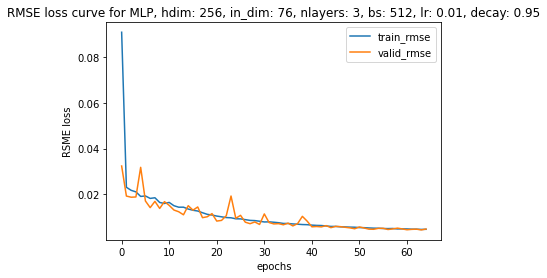

 44%|████▍     | 154/352 [01:41<01:34,  2.09it/s]


 88%|████████▊ | 308/352 [03:09<00:19,  2.27it/s]


100%|██████████| 352/352 [03:52<00:00,  1.52it/s]


Epoch 66 | T: 4.27 | Train RMSE: 0.00465 | Valid RMSE: 0.00449


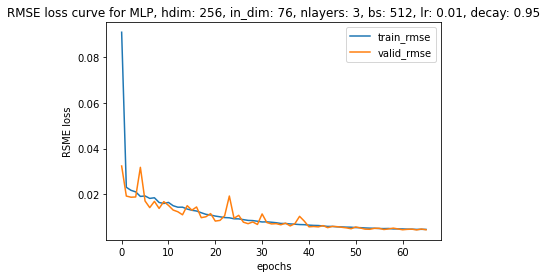

 44%|████▍     | 154/352 [02:00<01:35,  2.07it/s]


 88%|████████▊ | 308/352 [03:35<00:20,  2.10it/s]


100%|██████████| 352/352 [03:55<00:00,  1.49it/s]


Epoch 67 | T: 4.84 | Train RMSE: 0.00457 | Valid RMSE: 0.00497


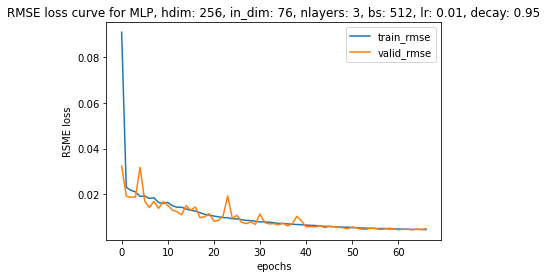

 44%|████▍     | 154/352 [01:48<01:37,  2.02it/s]


 88%|████████▊ | 308/352 [03:08<00:19,  2.27it/s]


100%|██████████| 352/352 [03:48<00:00,  1.54it/s]


Epoch 68 | T: 4.20 | Train RMSE: 0.00462 | Valid RMSE: 0.00442


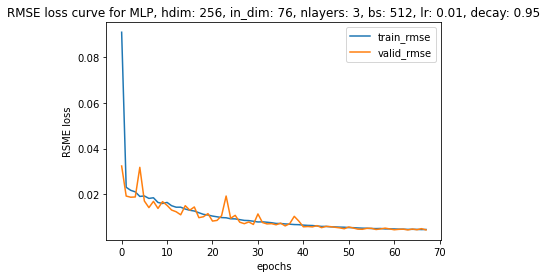

 44%|████▍     | 154/352 [02:04<01:30,  2.19it/s]


 88%|████████▊ | 308/352 [03:35<00:20,  2.18it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


Epoch 69 | T: 4.84 | Train RMSE: 0.00458 | Valid RMSE: 0.00445


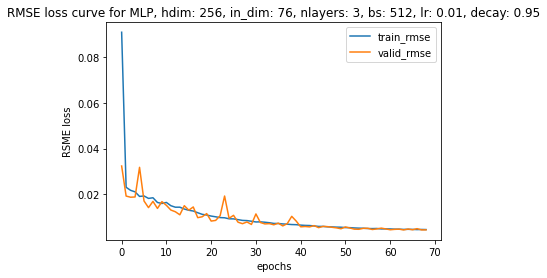

 44%|████▍     | 154/352 [01:41<01:37,  2.03it/s]


 88%|████████▊ | 308/352 [03:05<00:19,  2.28it/s]


100%|██████████| 352/352 [03:44<00:00,  1.57it/s]


Epoch 70 | T: 4.14 | Train RMSE: 0.00456 | Valid RMSE: 0.00448


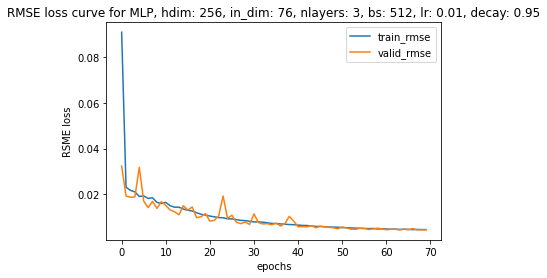

 44%|████▍     | 154/352 [02:03<01:30,  2.18it/s]


 88%|████████▊ | 308/352 [03:34<00:20,  2.20it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


Epoch 71 | T: 4.77 | Train RMSE: 0.00454 | Valid RMSE: 0.00438


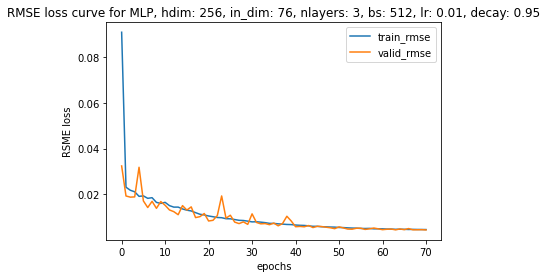

 44%|████▍     | 154/352 [01:52<01:39,  1.99it/s]


 88%|████████▊ | 308/352 [03:08<00:19,  2.23it/s]


100%|██████████| 352/352 [03:47<00:00,  1.55it/s]


Epoch 72 | T: 4.21 | Train RMSE: 0.00447 | Valid RMSE: 0.00437


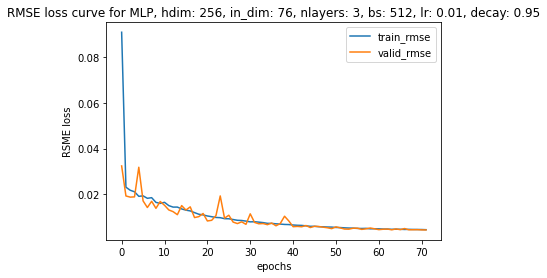

 44%|████▍     | 154/352 [02:03<01:36,  2.06it/s]


 88%|████████▊ | 308/352 [03:35<00:24,  1.79it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 73 | T: 4.76 | Train RMSE: 0.00450 | Valid RMSE: 0.00467


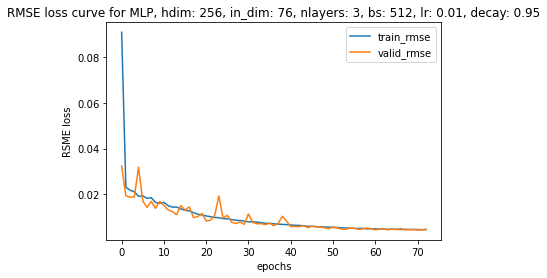

 44%|████▍     | 154/352 [01:49<01:39,  1.99it/s]


 88%|████████▊ | 308/352 [03:07<00:19,  2.30it/s]


100%|██████████| 352/352 [03:26<00:00,  1.70it/s]


Epoch 74 | T: 4.13 | Train RMSE: 0.00447 | Valid RMSE: 0.00432


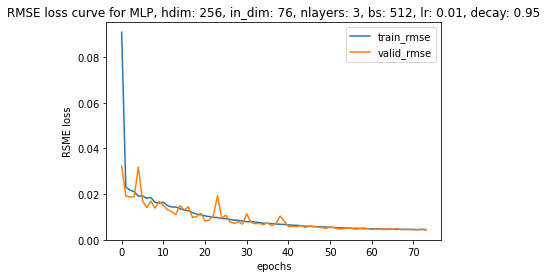

 44%|████▍     | 154/352 [02:08<01:40,  1.98it/s]


 88%|████████▊ | 308/352 [03:36<01:53,  2.59s/it]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


Epoch 75 | T: 4.34 | Train RMSE: 0.00445 | Valid RMSE: 0.00475


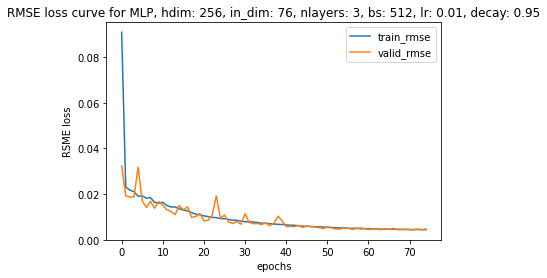

 44%|████▍     | 154/352 [02:16<02:57,  1.12it/s]


 88%|████████▊ | 308/352 [03:37<00:19,  2.22it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 76 | T: 4.65 | Train RMSE: 0.00446 | Valid RMSE: 0.00430


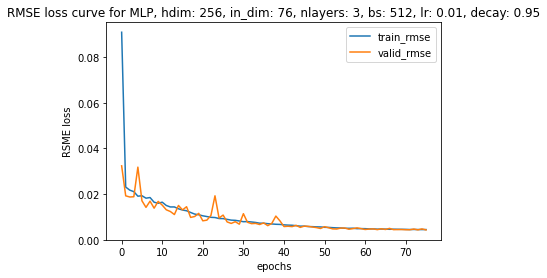

 44%|████▍     | 154/352 [02:04<01:33,  2.12it/s]


 88%|████████▊ | 308/352 [03:19<00:19,  2.22it/s]


100%|██████████| 352/352 [03:53<00:00,  1.51it/s]


Epoch 77 | T: 4.26 | Train RMSE: 0.00442 | Valid RMSE: 0.00436


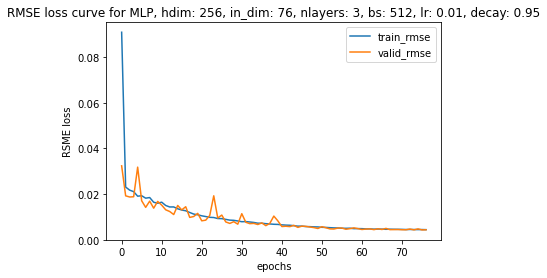

 44%|████▍     | 154/352 [02:07<01:29,  2.21it/s]


 88%|████████▊ | 308/352 [03:35<00:18,  2.32it/s]


100%|██████████| 352/352 [03:55<00:00,  1.50it/s]


Epoch 78 | T: 4.60 | Train RMSE: 0.00441 | Valid RMSE: 0.00437


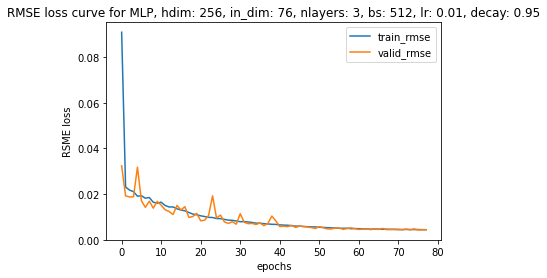

 44%|████▍     | 154/352 [02:04<01:31,  2.15it/s]


 88%|████████▊ | 308/352 [03:20<00:18,  2.32it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


Epoch 79 | T: 4.29 | Train RMSE: 0.00440 | Valid RMSE: 0.00437


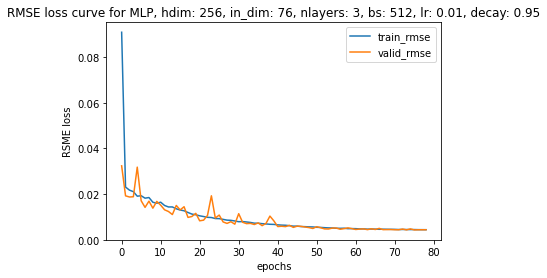

 44%|████▍     | 154/352 [02:07<01:31,  2.17it/s]


 88%|████████▊ | 308/352 [03:35<00:19,  2.21it/s]


100%|██████████| 352/352 [03:55<00:00,  1.50it/s]


Epoch 80 | T: 4.64 | Train RMSE: 0.00439 | Valid RMSE: 0.00456


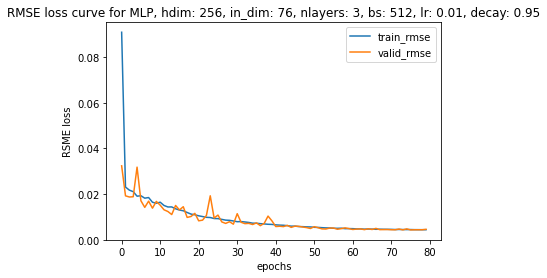

 44%|████▍     | 154/352 [02:02<01:46,  1.85it/s]


 88%|████████▊ | 308/352 [03:19<00:21,  2.07it/s]


100%|██████████| 352/352 [03:55<00:00,  1.50it/s]


Epoch 81 | T: 4.30 | Train RMSE: 0.00438 | Valid RMSE: 0.00431


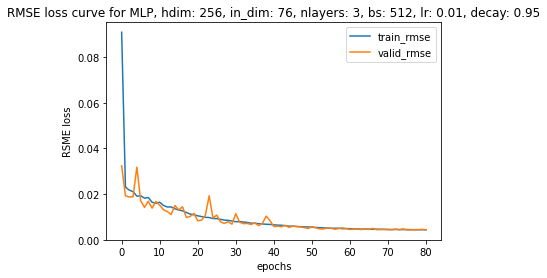

 44%|████▍     | 154/352 [02:06<01:26,  2.30it/s]


 88%|████████▊ | 308/352 [03:36<00:21,  2.05it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 82 | T: 4.30 | Train RMSE: 0.00438 | Valid RMSE: 0.00427


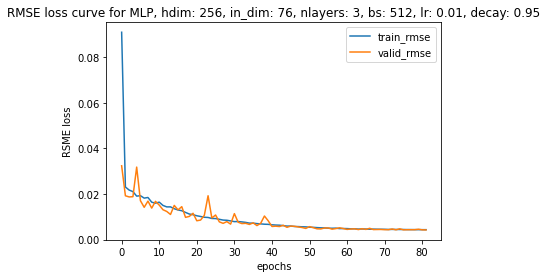

 44%|████▍     | 154/352 [01:58<01:33,  2.11it/s]


 88%|████████▊ | 308/352 [03:38<00:20,  2.12it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


Epoch 83 | T: 4.58 | Train RMSE: 0.00437 | Valid RMSE: 0.00425


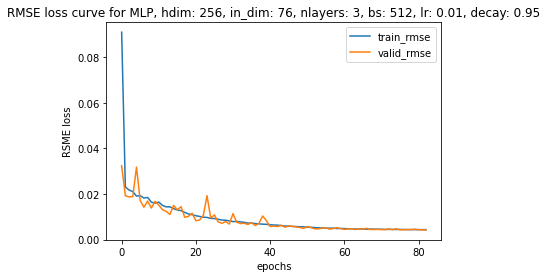

 44%|████▍     | 154/352 [02:03<01:42,  1.93it/s]


 88%|████████▊ | 308/352 [03:24<00:19,  2.24it/s]


100%|██████████| 352/352 [03:53<00:00,  1.51it/s]


Epoch 84 | T: 4.26 | Train RMSE: 0.00436 | Valid RMSE: 0.00425


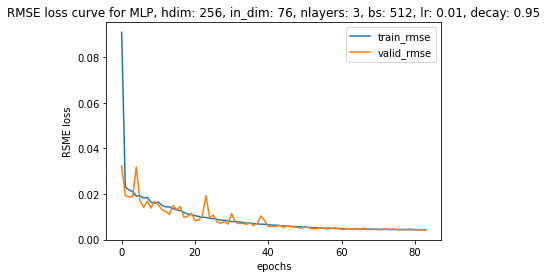

 44%|████▍     | 154/352 [02:01<01:33,  2.11it/s]


 88%|████████▊ | 308/352 [03:38<00:21,  2.02it/s]


100%|██████████| 352/352 [04:00<00:00,  1.47it/s]


Epoch 85 | T: 4.66 | Train RMSE: 0.00434 | Valid RMSE: 0.00426


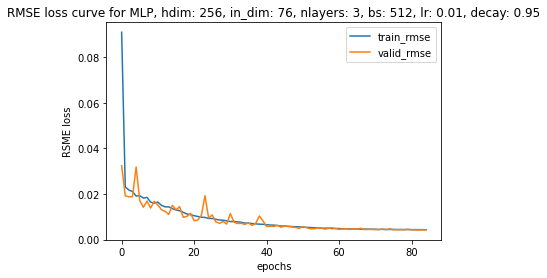

 44%|████▍     | 154/352 [01:55<04:52,  1.48s/it]


 88%|████████▊ | 308/352 [03:18<00:20,  2.20it/s]


100%|██████████| 352/352 [03:52<00:00,  1.51it/s]


Epoch 86 | T: 4.26 | Train RMSE: 0.00435 | Valid RMSE: 0.00424


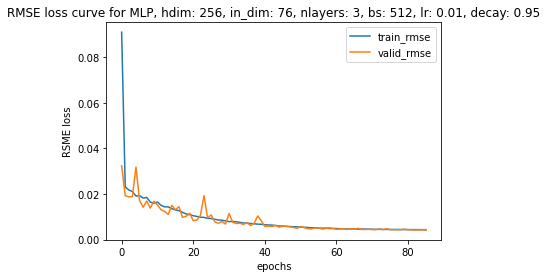

 44%|████▍     | 154/352 [01:54<01:33,  2.12it/s]


 88%|████████▊ | 308/352 [03:37<00:27,  1.63it/s]


100%|██████████| 352/352 [03:58<00:00,  1.48it/s]


Epoch 87 | T: 4.62 | Train RMSE: 0.00433 | Valid RMSE: 0.00425


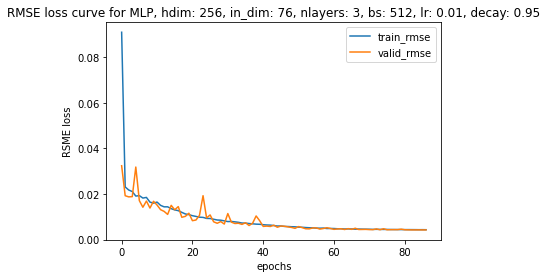

 44%|████▍     | 154/352 [01:37<01:34,  2.10it/s]


 88%|████████▊ | 308/352 [03:23<00:22,  1.93it/s]


100%|██████████| 352/352 [04:01<00:00,  1.46it/s]


Epoch 88 | T: 4.41 | Train RMSE: 0.00434 | Valid RMSE: 0.00424


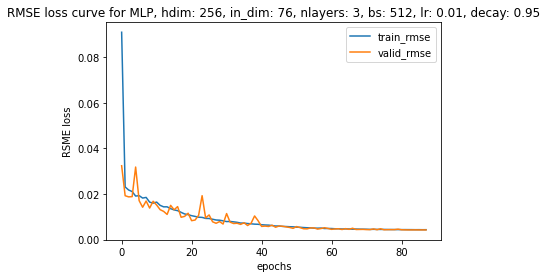

 44%|████▍     | 154/352 [01:50<01:31,  2.16it/s]


 88%|████████▊ | 308/352 [03:38<00:26,  1.65it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


Epoch 89 | T: 4.63 | Train RMSE: 0.00432 | Valid RMSE: 0.00428


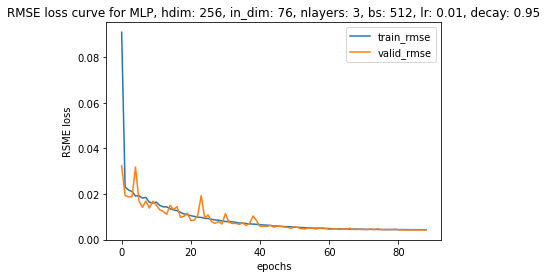

 44%|████▍     | 154/352 [01:34<01:33,  2.11it/s]


 88%|████████▊ | 308/352 [03:25<00:19,  2.22it/s]


100%|██████████| 352/352 [04:03<00:00,  1.44it/s]


Epoch 90 | T: 4.48 | Train RMSE: 0.00434 | Valid RMSE: 0.00429


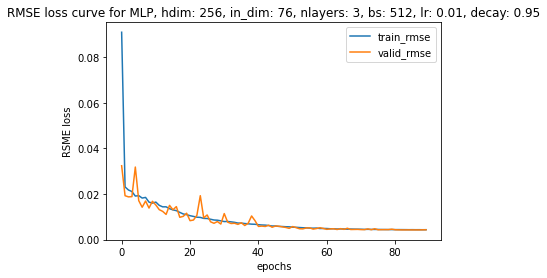

 44%|████▍     | 154/352 [01:48<01:36,  2.06it/s]


 88%|████████▊ | 308/352 [03:36<00:23,  1.89it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


Epoch 91 | T: 4.67 | Train RMSE: 0.00432 | Valid RMSE: 0.00424


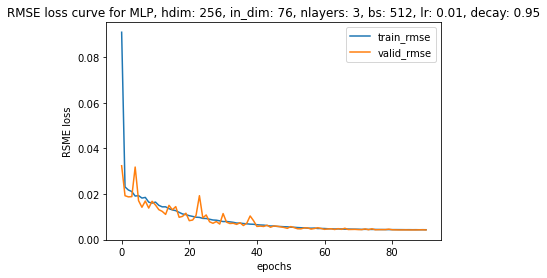

 44%|████▍     | 154/352 [01:49<05:29,  1.66s/it]


 88%|████████▊ | 308/352 [03:18<00:21,  2.04it/s]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


Epoch 92 | T: 4.43 | Train RMSE: 0.00432 | Valid RMSE: 0.00425


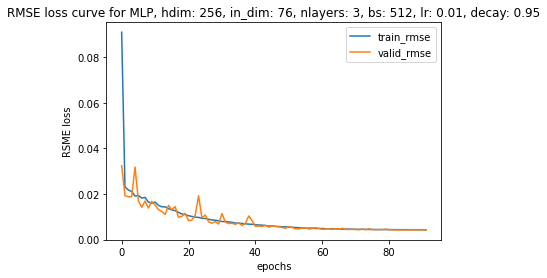

 44%|████▍     | 154/352 [01:47<01:37,  2.04it/s]


 88%|████████▊ | 308/352 [03:35<00:21,  2.06it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 93 | T: 4.70 | Train RMSE: 0.00430 | Valid RMSE: 0.00424


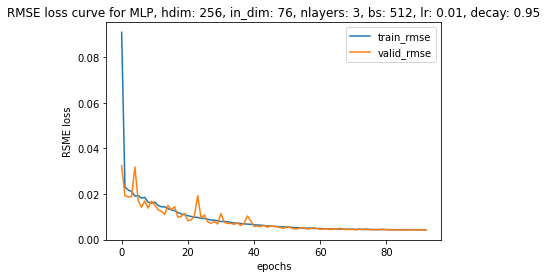

 44%|████▍     | 154/352 [01:45<01:49,  1.81it/s]


 88%|████████▊ | 308/352 [03:13<00:20,  2.13it/s]


100%|██████████| 352/352 [04:00<00:00,  1.47it/s]


Epoch 94 | T: 4.41 | Train RMSE: 0.00430 | Valid RMSE: 0.00427


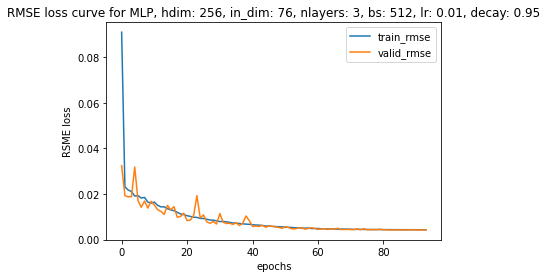

 44%|████▍     | 154/352 [01:47<01:37,  2.03it/s]


 88%|████████▊ | 308/352 [03:35<00:21,  2.04it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


Epoch 95 | T: 4.72 | Train RMSE: 0.00430 | Valid RMSE: 0.00430


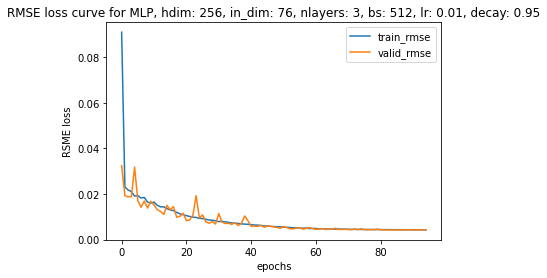

 44%|████▍     | 154/352 [01:47<01:40,  1.97it/s]


 88%|████████▊ | 308/352 [03:14<00:20,  2.13it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


Epoch 96 | T: 4.73 | Train RMSE: 0.00430 | Valid RMSE: 0.00422


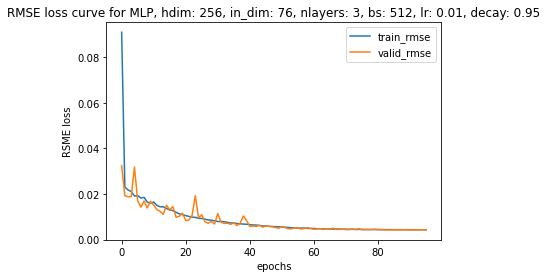

 44%|████▍     | 154/352 [01:29<01:36,  2.06it/s]


 88%|████████▊ | 308/352 [03:09<00:20,  2.12it/s]


100%|██████████| 352/352 [03:30<00:00,  1.67it/s]


Epoch 97 | T: 4.34 | Train RMSE: 0.00430 | Valid RMSE: 0.00422


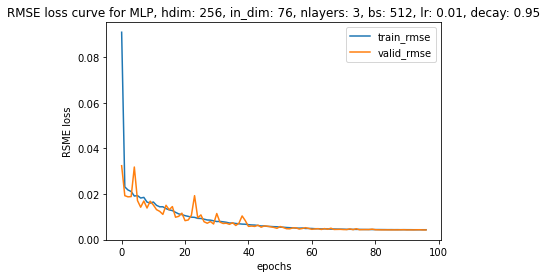

 44%|████▍     | 154/352 [01:48<01:42,  1.93it/s]


 88%|████████▊ | 308/352 [03:11<00:20,  2.15it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


Epoch 98 | T: 4.77 | Train RMSE: 0.00429 | Valid RMSE: 0.00424


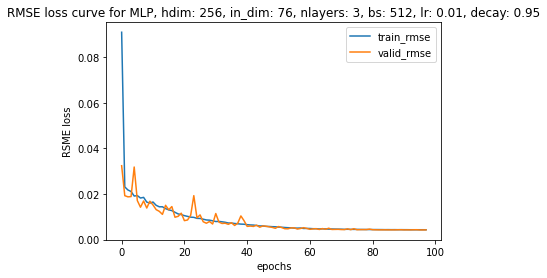

 44%|████▍     | 154/352 [01:39<08:18,  2.52s/it]


 88%|████████▊ | 308/352 [03:09<00:20,  2.15it/s]


100%|██████████| 352/352 [03:58<00:00,  1.48it/s]


Epoch 99 | T: 4.37 | Train RMSE: 0.00429 | Valid RMSE: 0.00428


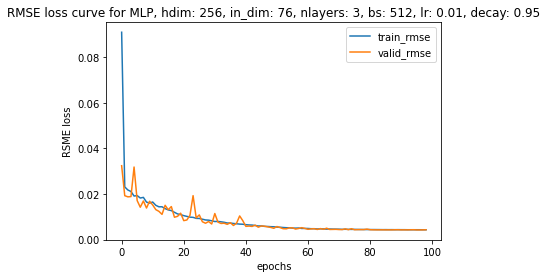

 44%|████▍     | 154/352 [01:45<01:37,  2.04it/s]


 88%|████████▊ | 308/352 [03:28<00:40,  1.10it/s]


100%|██████████| 352/352 [03:49<00:00,  1.53it/s]


Epoch 100 | T: 4.68 | Train RMSE: 0.00429 | Valid RMSE: 0.00422


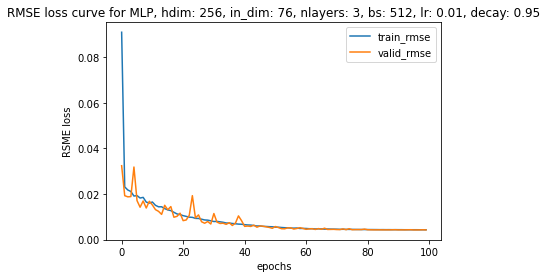

 44%|████▍     | 154/352 [01:45<01:32,  2.13it/s]


 88%|████████▊ | 308/352 [03:11<00:20,  2.11it/s]


100%|██████████| 352/352 [03:55<00:00,  1.49it/s]


Epoch 101 | T: 4.33 | Train RMSE: 0.00429 | Valid RMSE: 0.00423


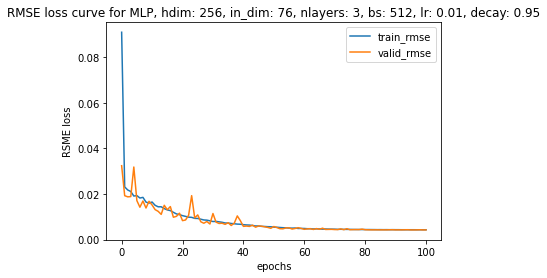

 44%|████▍     | 154/352 [01:55<01:35,  2.07it/s]


 88%|████████▊ | 308/352 [03:31<00:22,  1.96it/s]


100%|██████████| 352/352 [03:52<00:00,  1.52it/s]


Epoch 102 | T: 4.77 | Train RMSE: 0.00428 | Valid RMSE: 0.00422


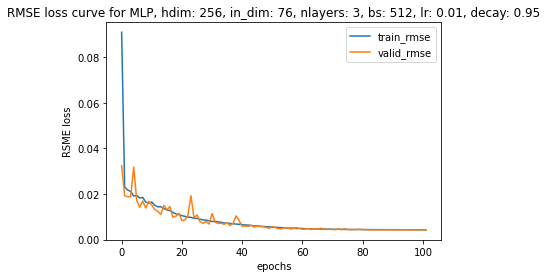

 44%|████▍     | 154/352 [01:44<01:33,  2.13it/s]


 88%|████████▊ | 308/352 [03:07<00:20,  2.19it/s]


100%|██████████| 352/352 [03:46<00:00,  1.56it/s]


Epoch 103 | T: 4.17 | Train RMSE: 0.00428 | Valid RMSE: 0.00422


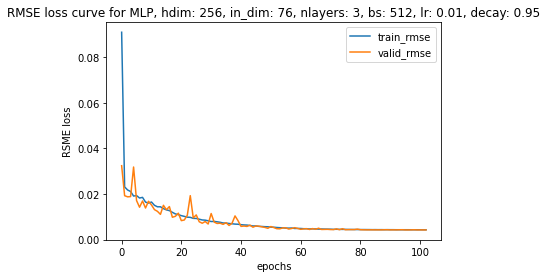

 44%|████▍     | 154/352 [01:35<01:46,  1.87it/s]


 88%|████████▊ | 308/352 [03:00<00:23,  1.89it/s]


100%|██████████| 352/352 [03:26<00:00,  1.71it/s]


Epoch 104 | T: 3.88 | Train RMSE: 0.00428 | Valid RMSE: 0.00422


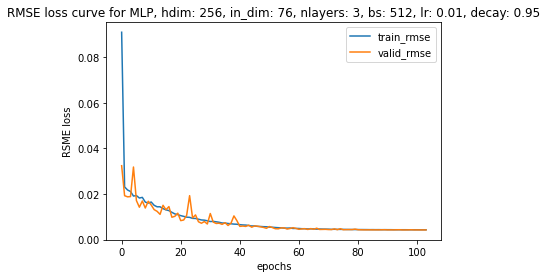

 44%|████▍     | 154/352 [01:28<01:56,  1.70it/s]


 88%|████████▊ | 308/352 [02:53<00:24,  1.76it/s]


100%|██████████| 352/352 [03:18<00:00,  1.77it/s]


Epoch 105 | T: 3.74 | Train RMSE: 0.00427 | Valid RMSE: 0.00424


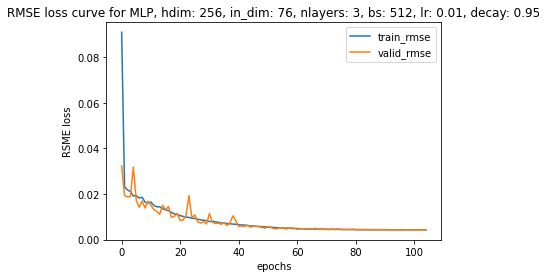

 44%|████▍     | 154/352 [01:26<01:49,  1.81it/s]


 88%|████████▊ | 308/352 [02:50<00:23,  1.88it/s]


100%|██████████| 352/352 [03:14<00:00,  1.81it/s]


Epoch 106 | T: 3.71 | Train RMSE: 0.00428 | Valid RMSE: 0.00421


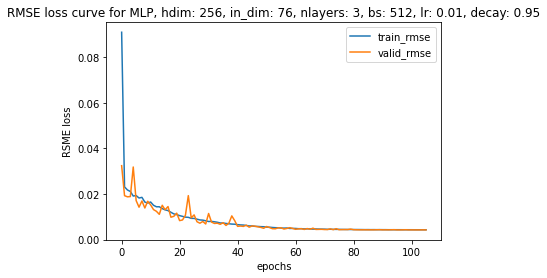

 44%|████▍     | 154/352 [01:30<01:44,  1.90it/s]


 88%|████████▊ | 308/352 [02:57<00:25,  1.70it/s]


100%|██████████| 352/352 [03:21<00:00,  1.74it/s]


Epoch 107 | T: 3.85 | Train RMSE: 0.00426 | Valid RMSE: 0.00425


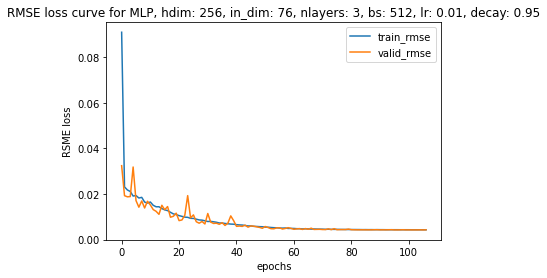

 44%|████▍     | 154/352 [01:31<01:45,  1.87it/s]


 88%|████████▊ | 308/352 [02:59<00:26,  1.68it/s]


100%|██████████| 352/352 [03:25<00:00,  1.72it/s]


Epoch 108 | T: 3.87 | Train RMSE: 0.00427 | Valid RMSE: 0.00422


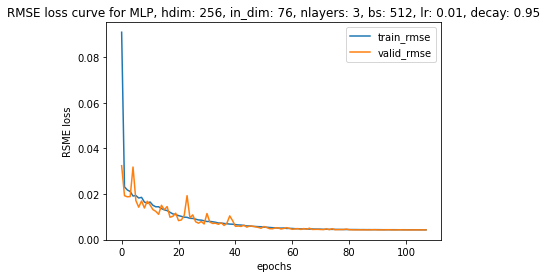

 44%|████▍     | 154/352 [01:31<01:52,  1.77it/s]


 88%|████████▊ | 308/352 [02:59<00:25,  1.73it/s]


 11%|█         | 108/1000 [8:13:17<67:54:13, 274.05s/it]


In [61]:
train_rmse = []
valid_rmse = []
min_rmse = 10e8

for i in tqdm(range(num_epoch)):
    start = time.time()

    # model.train() # if you use dropout or batchnorm. 
    train_rmse.append(train_epoch(train_loader, model, optimizer, loss_fun))
    #print(train_rmse)
    
    # model.eval()
    val_rmse, val_preds, val_trues = eval_epoch(valid_loader, model, loss_fun)
    valid_rmse.append(val_rmse)

    # save the best model
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model
        # torch.save([best_model, i, get_lr(optimizer)], name + ".pth")

    end = time.time()
    
    # Early Stopping
    if (len(train_rmse) > 100 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
        torch.save(best_model.state_dict(), f'mlp_hdim_{hidden_dim}_indim_{in_dim}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}_epoch_{i+1}.pt')
        break       

    # Learning Rate Decay        
    scheduler.step()
    
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.5f} | Valid RMSE: {:0.5f}".format(i + 1, (end-start) / 60, train_rmse[-1], valid_rmse[-1]))

    plt.figure()
    plt.plot(train_rmse, label="train_rmse")
    plt.plot(valid_rmse, label="valid_rmse")
    plt.xlabel('epochs')
    plt.ylabel('RSME loss')
    plt.title(f'RMSE loss curve for MLP, hdim: {hidden_dim}, in_dim: {in_dim}, nlayers: {num_layers}, bs: {batch_size}, lr: {learning_rate}, decay: {decay_rate}')
    plt.legend()
    plt.savefig(f'mlp_loss_curve_v1_hdim_{hidden_dim}_indim_{in_dim}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.png')
    plt.show()
    
# torch.save(model.state_dict(), 'baseline.pt')

# plt.figure()
# plt.plot(train_rmse)
# plt.plot(valid_rmse)
# plt.xlabel('epochs')
# plt.ylabel('RSME loss')
# plt.savefig('loss_curve.png')
# plt.show()

In [41]:
train_rmse

[0.11066,
 0.01812,
 0.01729,
 0.01668,
 0.01686,
 0.01728,
 0.01708,
 0.01717,
 0.01538,
 0.01467,
 0.0146,
 0.01374,
 0.0127,
 0.01234,
 0.01189,
 0.01135,
 0.01094,
 0.01089,
 0.01023,
 0.00992,
 0.00986,
 0.00959,
 0.00934,
 0.00887,
 0.00886,
 0.00843,
 0.00819,
 0.00814,
 0.00788,
 0.00783,
 0.00763,
 0.00739,
 0.00709,
 0.0071,
 0.00677,
 0.00657,
 0.00651,
 0.00637,
 0.00629,
 0.0061,
 0.00603,
 0.00599,
 0.00584,
 0.00583,
 0.0058,
 0.00575,
 0.00565,
 0.00565,
 0.00558,
 0.0056,
 0.00554,
 0.00552,
 0.00546,
 0.00548,
 0.00544,
 0.00544,
 0.00545,
 0.0054,
 0.00537,
 0.00534,
 0.00538,
 0.00538,
 0.00535,
 0.00534,
 0.00531,
 0.00531,
 0.0053,
 0.00531,
 0.0053,
 0.00527,
 0.00529,
 0.00528,
 0.00528,
 0.00526,
 0.00525,
 0.00526,
 0.00526,
 0.00525,
 0.00525,
 0.00526,
 0.00524,
 0.00523,
 0.00523,
 0.00523,
 0.00523,
 0.00523,
 0.00522,
 0.00522,
 0.00523,
 0.00521,
 0.00521,
 0.00521,
 0.00521,
 0.00522,
 0.00521,
 0.00521,
 0.00521,
 0.00521,
 0.0052,
 0.0052,
 0.0052,
 0

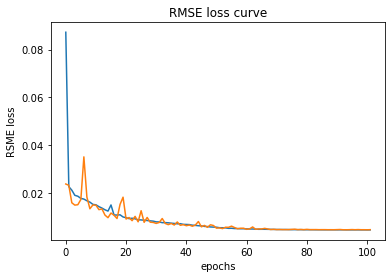

In [24]:
plt.figure()
plt.plot(train_rmse)
plt.plot(valid_rmse)
plt.xlabel('epochs')
plt.ylabel('RSME loss')
plt.title('RMSE loss curve')
plt.savefig('loss_curve_v1.png')
plt.show()

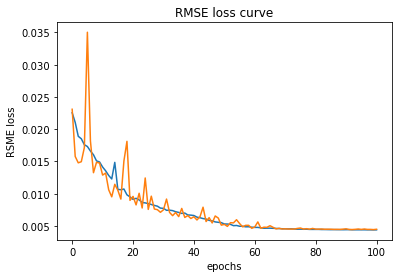

In [25]:
plt.figure()
plt.plot(train_rmse[1:])
plt.plot(valid_rmse[1:])
plt.xlabel('epochs')
plt.ylabel('RSME loss')
plt.title('RMSE loss curve')
plt.savefig('loss_curve_v2.png')
plt.show()

# Evaluation and Submission

In [9]:
model.load_state_dict(torch.load('baseline_mlp.pt'))

<All keys matched successfully>

In [10]:
best_model = model

In [62]:
test_path = "../val_in/val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        inp_scene = np.dstack([test_sample['p_in'], test_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        preds = best_model(inp).cpu().data.numpy()
        
        # De-Normalization ! 
        preds = preds * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        test_preds.append(preds)

In [63]:
print(len(test_preds))
print(test_preds[0])

3200
[[[1712.39735301  337.46815788]
  [1713.69616764  338.23900098]
  [1714.67077284  338.9173525 ]
  [1716.80549845  339.78566078]
  [1717.81204598  340.46545203]
  [1718.29763181  341.49891448]
  [1719.01191222  341.98187755]
  [1720.67978041  343.08872247]
  [1722.80430945  343.77837367]
  [1721.94644462  344.50678844]
  [1723.66831303  345.21707573]
  [1724.42566877  345.93776832]
  [1726.69888051  346.78877806]
  [1727.52157756  347.7337409 ]
  [1728.76951337  348.34843903]
  [1730.13803927  349.03643236]
  [1731.11847108  349.75705952]
  [1731.40761679  350.58590617]
  [1733.93116482  351.3454714 ]
  [1732.97029379  352.13557631]
  [1735.96038711  352.91427246]
  [1735.64439736  353.79977021]
  [1737.76018648  354.56871548]
  [1737.65936525  355.38903285]
  [1739.69649508  356.01908806]
  [1740.41826686  356.72568878]
  [1741.75214522  357.31063254]
  [1744.01401587  358.40951533]
  [1744.48680396  358.90872987]
  [1744.29150835  359.39284909]]]


# Generate Submission File

### Steps to create submission file 
Run the below cells. The last cell will generate a submission file "test_submission.csv" that you can submit to Kaggle.

In [64]:
# Submission Files
sample_sub = pd.read_csv('sample_submission.csv')

In [16]:
# Convert to int
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1).astype(int) # This converts predictions to integer format (undesirable)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df.to_csv('test_submission.csv', index=None)

In [65]:
# Convert to float (Attempt 2) and save for later use
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df["ID"] = sub_df["ID"].astype(int)
sub_df.to_csv(f'test_submission_mlp_hdim_{hidden_dim}_indim_{in_dim}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.csv', index=None)

In [66]:
# Convert to float
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1) # this keeps predictions in floating-point format (desirable)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df["ID"] = sub_df["ID"].astype(int) # ID column should be in int format or else there will be error when submitting to kaggle
sub_df.to_csv('test_submission.csv', index=None)

In [67]:
sub_df

ID           v1           v2           v3           v4           v5  \
0     10002  1712.397353   337.468158  1713.696168   338.239001  1714.670773   
1     10015   725.514010  1229.482914   725.500311  1229.514506   725.471616   
2     10019   574.571195  1245.349229   574.693451  1244.956630   575.034677   
3     10028  1691.178818   315.382191  1691.971730   315.921282  1692.387131   
4      1003  2122.902016   676.832702  2121.873548   675.734420  2120.203455   
...     ...          ...          ...          ...          ...          ...   
3195   9897   255.906808   805.527954   256.092782   805.411615   256.383887   
3196     99   588.185260  1154.435486   588.150725  1153.622523   588.293552   
3197   9905  1753.820036   444.159894  1753.861135   444.501474  1753.561771   
3198   9910   574.754640  1288.957117   574.652121  1288.755679   574.643784   
3199   9918   584.589296  1164.373558   584.631288  1163.757840   584.816832   

               v6           v7           v8           v9  ...          v51  \
0      338.917353  1716.805498   339.785661  1717.812046  ...  1740.418267   
1     1228.993763   725.424835  1228.972993   725.447979  ...   724.237495   
2     1245.022403   575.108238  1244.774161   575.491239  ...   579.444183   
3      316.358166  1693.340681   316.960399  1694.165841  ...  1708.383629   
4      674.627737  2119.154896   673.546839  2117.927568  ...  2091.375890   
...           ...          ...          ...          ...  ...          ...   
3195   805.198034   256.639253   805.012154   256.861177  ...   261.669344   
3196  1153.135312   588.274523  1152.308706   588.288576  ...   588.804758   
3197   444.805430  1753.869334   445.111933  1753.551049  ...  1752.027738   
3198  1288.515355   574.563810  1288.258500   574.389170  ...   571.775737   
3199  1162.405463   584.980335  1161.667391   584.765909  ...   585.586005   

              v52          v53          v54          v55          v56  \
0      356.725689  1741.752145   357.310633  1744.014016   358.409515   
1     1226.525801   724.217798  1226.624475   724.291708  1226.113758   
2     1242.589954   579.602899  1242.970294   579.684700  1242.364107   
3      328.056833  1709.185207   328.456381  1709.889637   329.067703   
4      649.424140  2090.383765   648.373852  2088.934414   647.334792   
...           ...          ...          ...          ...          ...   
3195   801.577326   261.907229   801.294399   262.144241   801.239825   
3196  1137.001617   588.796151  1136.477221   588.792229  1135.596677   
3197   452.121033  1751.673083   452.406541  1751.948692   452.752208   
3198  1283.052680   571.513011  1283.027490   571.502168  1282.631778   
3199  1142.528090   585.420904  1141.554561   585.714439  1140.857227   

              v57          v58          v59          v60  
0     1744.486804   358.908730  1744.291508   359.392849  
1      724.088826  1226.254528   724.123968  1226.442804  
2      579.833284  1241.974337   580.302974  1242.522059  
3     1710.842380   329.562546  1710.881482   329.838552  
4     2088.002689   646.329337  2086.716368   645.221905  
...           ...          ...          ...          ...  
3195   262.307623   801.090149   262.471167   801.009139  
3196   588.760599  1134.853134   588.805012  1134.510983  
3197  1751.457179   453.021312  1751.740356   453.323448  
3198   571.234432  1282.250077   571.208821  1282.405780  
3199   585.426967  1140.300603   585.326965  1139.717149  

[3200 rows x 61 columns]

In [ ]:
# Ensemble Method 